# E207 HW6
### Partners: Rafael Burger, Alec Candidato
#### Time Spent: 
Rafael: _______
Alec:   _______

In [84]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

### In this problem, we will apply probability and statistics to do state estimation on a robot. 

### Part 1(a)

We will program our robot to move according to a Markov chain. There are 11 positions, x = 0, 1, 2, ... 10.
- Positions 0 & 10: 
    - Robot stays in place (P = 0.9)
    - Robot moves away from boundary    (P = 0.1)
- Positions 1, 2, ... 9: 
    - Robot stays in place              (P = 0.8)
    - Robot moves left                  (P = 0.1)
    - Robot moves right                 (P = 0.1)

The following code creates the state transition matrix A and prints its values. 

In [85]:
NUM_POS = 11
A = np.zeros((NUM_POS, NUM_POS))

A[0,0:2] = [0.9,0.1] # set first row
A[10,9:] = [0.1,0.9] # set last row

for i in range(1,NUM_POS-1): # set middle rows
    A[i,i-1:i+2] = [0.1, 0.8, 0.1]

print(A)    # print state transition matrix

[[0.9 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.8 0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.8 0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.8 0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.8 0.1 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.8 0.1]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.9]]


### Part 1(b)

In this step, we will simulate the robot's position over 50 time steps, assuming the robot starts at x = 5 in step 0. 

In [92]:
NUM_STEPS = 50
NUM_TRIALS = 10

MOVE = 0.1          # probability of moving to the left or to the right. 
STAY = 1-2*MOVE     # probability of staying in place

simData = np.zeros((NUM_TRIALS, NUM_STEPS)) # allocate matrix for simulation data
simData[:,0] = 5                            # initialize starting positions for all trials

for trial in range(NUM_TRIALS):
    for step in range(1, NUM_STEPS):
        cur_pos = simData[trial, step-1]
        p = np.random.random() # roll die for next move

        if (cur_pos == 0):
            if p < (STAY+MOVE):
                next_pos = cur_pos
            else:
                next_pos = cur_pos+1

        elif (cur_pos == 10):
            if p < (STAY+MOVE):
                nextpos = cur_pos
            else: 
                nextpos = cur_pos-1

        else: 
            if p < MOVE:
                nextpos = cur_pos - 1
            elif p < (MOVE+STAY):
                nextpos = cur_pos
            else:
                nextpos = cur_pos + 1
        
        simData[trial, step] = nextpos

Now let's plot the results

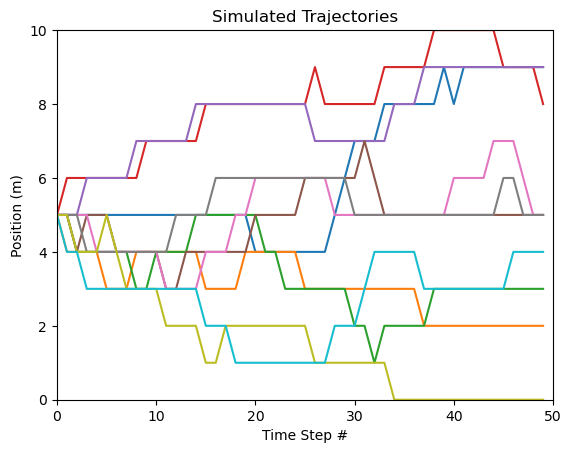

In [102]:
plt.figure(1)
for trial in range(NUM_TRIALS):
    plt.plot(simData[trial,:])
plt.xlim((0,50))
plt.ylim((0,10))
plt.xlabel("Time Step #")
plt.ylabel("Position (m)")
plt.title("Simulated Trajectories")
#legend = ["Trajectory " + str(i) for i in range(1,11)]
#plt.legend(legend)
plt.show()

### Part 1(c)

In class, we derived the following relationship between the initial state probability vector $\pi$, the state transition matrix $S$, and the probability mass function of a random variable at a time step $n$. 

$ \pi S^n = [P(S_{n+1} = 0), P(S_{n+1} = 1), P(S_{n+1} = 2), ...] $

We will use this to calculate the pmf of the robot's position at time steps 1, 2, and 3. 

In [111]:
# create initial state probability vector
pi = np.zeros(11)
pi[5] = 1

# compute pmfs
pmf1 = pi @ A
pmf2 = pi @ (np.linalg.matrix_power(A, 2)) # is there a shortcut for raising a matrix to a power? 
pmf3 = pi @ (np.linalg.matrix_power(A, 3))

Now let's plot the results. 

In [123]:
def plotPositionPMF(pmf, title):
    plt.stem(pmf)
    plt.xlabel("Position (m)")
    plt.ylabel("Probability")
    plt.xlim((0,10))
    plt.ylim((0,1))
    plt.title(title)
    plt.show()

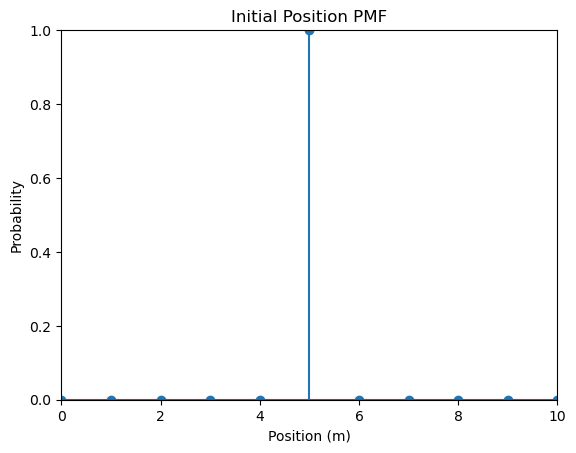

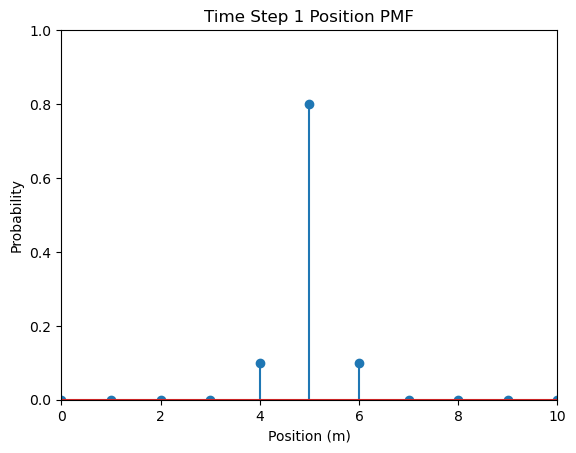

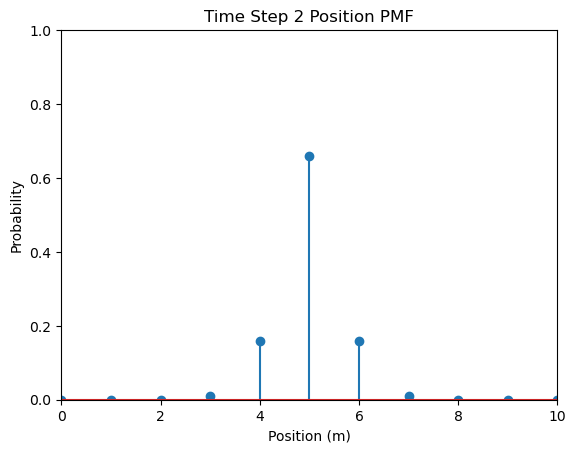

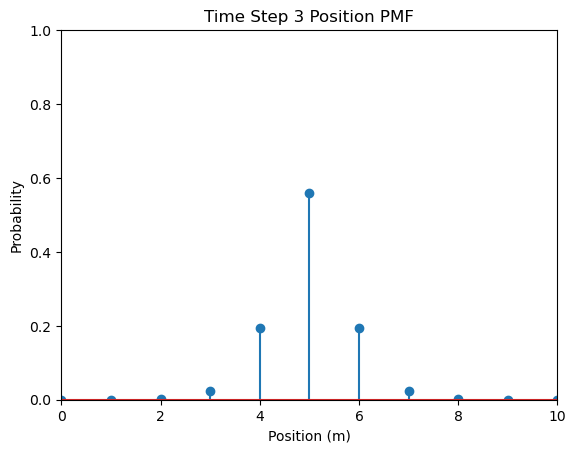

In [124]:
plotPositionPMF(pi, "Initial Position PMF")
plotPositionPMF(pmf1, "Time Step 1 Position PMF")
plotPositionPMF(pmf2, "Time Step 2 Position PMF")
plotPositionPMF(pmf3, "Time Step 3 Position PMF")